# Se connecter au drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/PLDAC/darknet
%ls

Mounted at /content/gdrive
/content/gdrive/My Drive/PLDAC/darknet
0041408.txt             evaluation.py          __pycache__/
3rdparty/               image_yolov3.sh        README.md
backup/                 image_yolov4.sh        resultats/
bad.list                include/               results/
build/                  json_mjpeg_streams.sh  scripts/
build.ps1               libdarknet.so          split_aug.py
cfg/                    LICENSE                src/
cmake/                  Makefile               uselib
CMakeLists.txt          net_cam_v3.sh          vcpkg.json
darknet                 net_cam_v4.sh          vcpkg.json.opencv23
DarknetConfig.cmake.in  obj/                   video_yolov3.sh
darknet_images.py       prediction/            video_yolov4.sh
darknet.py              predictions.jpg        weights_cfg/
darknet_video.py        prediction_stats/      yolov4.conv.137
data/                   process.py             yolov4.weights


In [3]:
!chmod +x ./darknet
%ls

0041408.txt             evaluation.py          __pycache__/
3rdparty/               image_yolov3.sh        README.md
backup/                 image_yolov4.sh        resultats/
bad.list                include/               results/
build/                  json_mjpeg_streams.sh  scripts/
build.ps1               libdarknet.so          split_aug.py
cfg/                    LICENSE                src/
cmake/                  Makefile               uselib
CMakeLists.txt          net_cam_v3.sh          vcpkg.json
darknet*                net_cam_v4.sh          vcpkg.json.opencv23
DarknetConfig.cmake.in  obj/                   video_yolov3.sh
darknet_images.py       prediction/            video_yolov4.sh
darknet.py              predictions.jpg        weights_cfg/
darknet_video.py        prediction_stats/      yolov4.conv.137
data/                   process.py             yolov4.weights


# Fonctions d'affichage sur le drive

In [4]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [5]:
%cd ./cfg
!sed -i 's/batch=32/batch=1/' yolov4-custom.cfg
!sed -i 's/subdivisions=32/subdivisions=1/' yolov4-custom.cfg
%cd ..

/content/gdrive/MyDrive/PLDAC/darknet/cfg
/content/gdrive/MyDrive/PLDAC/darknet


# Test de prédiction sur l'image 0041408

In [6]:
!./darknet detector test data/piford.data cfg/yolov4-custom.cfg backup/yolov4-custom_best.weights data/piford/0041408.bmp -thresh 0.3 -dont_show -map -ext_output -out 0041408.txt

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv   

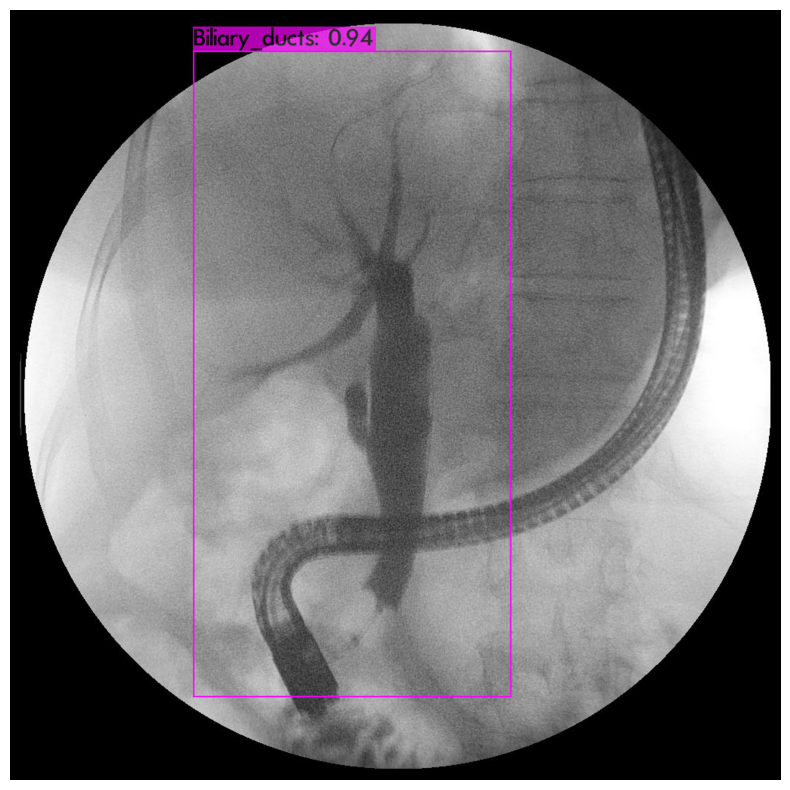

In [7]:
imShow('predictions.jpg')

# Prédictions avec evaluation.py



In [8]:
import evaluation 

## Cas d'une prédiction pour un modèle dont les poids sont dans backup

Cette première utilisaiton de evaluation.py correspond par exemple à un cas où l'on vient d'entraîner un modèle et que l'on souhaite désormais effectuer toutes les prédictions sur les images de test ainsi que d'évaluer notre modèle.   
On obtient alors les résultats des prédictions dans le dossier 'prediction' et toutes les statistiques d'évaluation dans le dossier 'prediction_stats'. Ces deux dossiers se trouvent dans le dossier darknet.    
Dans le dossier 'prediction' on trouve pour chaque image de test : 
  - Un fichier .txt avec le résultat de la prédiction.
  - Une image au format .jpg avec la bbox réelle et celle prédite ainsi que le score de confiance et le score IoU.     
  
Dans le dossier 'prediction_stats' on trouve :
  - avg_iou.txt : contenant la moyenne des scores IoU obtenus lors des prédictions.
  - best_score_map.txt : contenant le meilleur score MAP obtenu (selon le threshold utilisé pour effectuer la prédiction).
  - best_threshold.txt : contenant le threshold permettant de maximiser la MAP. 
  - chart.png : correspondant à la courbe d'apprentissage qui avait été obtenue lors du dernier train effectué.
  - confidences.txt : contenant les scores de confiance pour chaque image.
  - confusion_matrix.jpg : la matrice de confusion obtenue sur nos données test (vrai positif, vrai négatig, faux positif et faux négatif).
  - coord_pred.txt : contenant les coordonnées prédites pour chaque image. 
  - coord_true.txt : contenant les coordonées réelles pour chaque image. 
  - MAP_vs_threshold.jpg : courbe présentant l'évolution de la MAP en fonction du threshold. 
  - Precisions_curve.jpg : courbe présentant l'évolution de la précision en fonction du threshold. 
  - Precisions_recall_curve : courbe présentant la précision en fonction du rappel. 
  - prediction_times.txt : contenant les temps de chaque prédiction ainsi que le temps moyen de prédiction (en ms et FPS).
  - Recalls_curve.jpg : courbe présentant l'évolution du recall en foncion du threshold. 
  - scores_ciou.txt : contenant les score CIoU obtenus pour chaque image. 
  - test.txt : fichier listant les images ayant été utilisées pour le test.
  - train.txt : fichier listant les images ayant été utilisées pour l'entraînement.
  - yolov4-custom_best.weights : meilleur poids ayant été obtenu lors de l'appprentissage. 



In [9]:
evaluation.run('data/test.txt', '', '', '', True)


Output hidden; open in https://colab.research.google.com to view.

## Cas pour évaluer tous les modèles 

Ce second cas de figure permet de

In [ ]:
evaluation.run_all('data/test.txt')

start all: 
start :
Image data/piford/0025402.bmp prédite en 685.004 ms
Image data/piford/0021406.bmp prédite en 864.747 ms
Image data/piford/0039404.bmp prédite en 789.518 ms
Image data/piford/0016403.bmp prédite en 688.043 ms
Image data/piford/0019401.bmp prédite en 708.972 ms
Image data/piford/0044413.bmp prédite en 699.825 ms
Image data/piford/0041408.bmp prédite en 688.887 ms
Image data/piford/0021201.bmp prédite en 689.913 ms
Image data/piford/0021101.bmp prédite en 672.464 ms
Image data/piford/0021001.bmp prédite en 685.455 ms
Image data/piford/0016001.bmp prédite en 661.05 ms
Image data/piford/0016201.bmp prédite en 811.137 ms
Image data/piford/0016101.bmp prédite en 702.743 ms
Image data/piford/0019201.bmp prédite en 704.797 ms
Image data/piford/0019101.bmp prédite en 691.879 ms
Image data/piford/0019001.bmp prédite en 697.968 ms
best map :  1.0
threshold :  0.9900000000000002


/content/gdrive/MyDrive/PLDAC/darknet/evaluation.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,5))


average IoU :  0.8715224519640701
done
start :
Image data/piford/0025402.bmp prédite en 901.869 ms
Image data/piford/0021406.bmp prédite en 698.088 ms
Image data/piford/0039404.bmp prédite en 827.374 ms
Image data/piford/0016403.bmp prédite en 663.889 ms
Image data/piford/0019401.bmp prédite en 868.93 ms
Image data/piford/0044413.bmp prédite en 680.705 ms
